In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from random import seed

In [2]:
def preprocessing(epochs, orig_dataset):
    
    dataset = (orig_dataset - orig_dataset.min())/(orig_dataset.max()-orig_dataset.min())
    dataset['y'] = pd.to_numeric(orig_dataset['y'], downcast='integer')
    x = dataset #;y=x.pop('y')
    training_sets = np.zeros(5)
    training_sets = list(training_sets)
    for counter in range(epochs):
        new_set = pd.DataFrame(data=[],columns=x.columns)
        for k in range(len(x)//epochs):
            i = random.randrange(len(x))
            new_set.loc[k] = x.iloc[i]
            x.drop(i)
        training_sets[counter] = new_set
    return training_sets
# print(data[0])

In [3]:
def network_create(layers):
    network = []
    
    for i in range(len(layers)):
        layer = {}
        inputs, nodes = layers[i]
        # weight = 0.5+np.random.randn(nodes, inputs)*0.25
        weight = np.random.rand(nodes, inputs)
        # bias = 2+np.random.randn(nodes)*3
        bias = np.random.randn(nodes)
        layer['w'] = weight.astype('float64')
        layer['b'] = bias.astype('float64')
        layer['del'] = np.zeros(nodes)
        network.append(layer)
    # for i in network:
    #     print(i)
    return network




In [4]:
def sigmoid(z):
    z = z.astype('float64')
    return 1/(1+np.exp(-z))

In [5]:
def softmax(z):
    a = np.zeros(z.shape)
    for i in range(len(z)):
        a[i] = z[i]/np.sum(z)
    return a

In [6]:
def Dense(A_in,W,B,func):
    Z = A_in @ W.T + B
    A_out = func(Z)
    return A_out

In [7]:
def forward_prop(data, network):
    a_in = data
    for layer in range(len(network)):
        a_out = Dense(a_in, network[layer]['w'], network[layer]['b'],sigmoid)
        network[layer]['z'] = a_out
        a_in = a_out
    # print(network) 
    
    return network
    

In [8]:
def transfer_derivative(z):
    return z*(1.0-z)

In [9]:
def update_w_b(network,layers,learning_rate,data):
    # print(network)
    for i in range(len(network)):
        for k in range(layers[i][1]):
            if i>0:
                for j in range(layers[i][0]):
                    # print(network[i]['del'])#*network[i-1]['z'][j])
                    network[i]['w'][k][j] -= learning_rate*network[i]['del'][k]*network[i-1]['z'][j]
                network[i]['b'][k] -= learning_rate*network[i]['del'][k]
            else:
                for j in range(layers[i][0]):
                    network[i]['w'][k][j] -= learning_rate*network[i]['del'][k]*data[:-1].iloc[j]
                network[i]['b'][k] -= learning_rate*network[i]['del'][k]
    # print(network)
    return network

In [10]:
def backpropagate(data, network, layers, l_rate):
    data_y = np.zeros(layers[-1][1])
    data_y[int(data['y']-1)] = 1
    expected = data_y
    for i in reversed(range(len(network))):
        layer = network[i]
        if i != len(network)-1:
            for j in range(len(layers[i][1])):
                for n in range(len(layers[i+1][1])):
                    network[i]['del'][j]+=network[i+1]['w'][j]*network[i+1]['del'][n]
        else:
            layer['del'] = network[i]['z'] - data_y
        network[i]['del'] *= transfer_derivative(network[i]['z'])
        return update_w_b(network,layers,l_rate,data)
                

In [11]:
def predict(data_row_test, network,output):
    y = data_row_test.pop('y')
    a_in = data_row_test
    network = forward_prop(a_in,network)
    a_out = network[-1]['z']
    output[0].append(y)
    output[1].append(list(a_out).index(max(list(a_out)))+1)

######## print this line to see the predictions made by the model#########
    # print('pred-',y,a_out,list(a_out).index(max(list(a_out)))+1) #
#########################################################################
    
    return output

In [12]:
def accuracy_metric(test,network,accuracy):
    for test_item in range(test.shape[0]):
    # print(test.iloc[test_item])
        accuracy = predict(test.iloc[test_item], network, accuracy)
    return accuracy

In [13]:
def evaluate(predicted):
    c = 0
    samples = len(predicted[0])
    for i in range(samples):
        if predicted[0][i] == predicted[1][i]:
            c+=1
    accuracy = c/samples*100
    return accuracy

def score(folds, split_set):
    accuracy = [[],[]]
    a = np.zeros(folds)
    for i in range(folds):
        accuracy = accuracy_metric(sets[i],network,accuracy)
        a[i] = evaluate(accuracy)
        # print(a[i], end=" ")
    # print("\ntotal average score = ", np.sum(a)/folds)
    return a
    

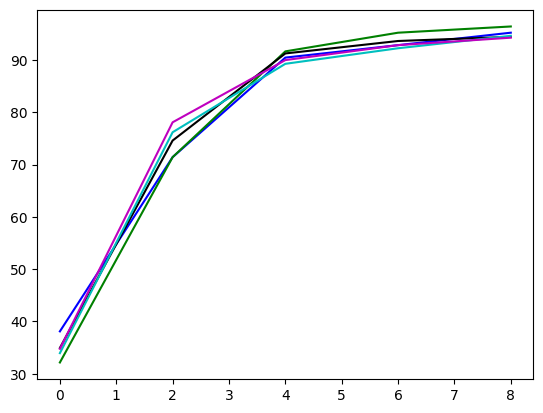

In [14]:


##################### initialization ##########################

orig_dataset = pd.read_csv('seeds_dataset.csv')

n_folds = 5

# change the parameters for layer information
# (input_nodes, current_nodes) for the given layer. 
# The first node contains the input layer and he last node is the output layer

layer_info = [(7,5),(5,3)]
lr = 1 # learning rate
nepochs = 10 # epochs
random_selection = 42
random_wb = 42
seed(random_selection) # seed 42 gives decent results
np.random.seed(random_wb) 

# print(network)

###################### main ###########################

network = network_create(layer_info)
sets = preprocessing(n_folds, orig_dataset)
epochs = np.arange(0,nepochs,2)
entire = pd.DataFrame([],columns = [0,1,2,3,4])
c = 0
# print(epochs)
for epoch in epochs:
    for _ in range(epoch):
        accuracy = [[],[]]
        for i in range(n_folds):
            sets_cpy = sets[:]
            test = sets_cpy.pop(i)
            train = pd.concat(sets_cpy)
            # print('\n\ntest------',test)
            # print('\n\ntrain------',train)
            for item in range(train.shape[0]):
                data_row = train.iloc[item]
                or_data_row = data_row[:]
                y = data_row.pop('y')
                network = backpropagate(or_data_row, forward_prop(data_row, network), layer_info,lr)
    a = list(score(n_folds, sets))
    entire.loc[c] = a
    c+=1
colors = ['b','g','k','c','m']
# print(entire.shape)
for i in range(entire.shape[1]):
    # print(entire[i])
    plt.plot(epochs, entire[i], colors[i])
plt.show()

In [15]:
a = score(n_folds, sets)

In [16]:
a =predict(sets[1], network,accuracy)
    
# for i in range entire.shape[]

    
    